# STAT 426 Final Project
Isabelle Tooley
December 10, 2020

## Introduction

I am very interested in movies and stories. I always have been. But I assumed that my choice to pursue an education and career path in the field of statistics/data science meant that my love of words and storytelling would remain just a side interest. So I got very excited when I started learning about all the applications of natural language processing. It bridged two of my passions: statistics and stories.

Most stories are written. Books, scripts for plays and tv shows, movie screenplays: all of these are a collection of words that convey a story. The motivation for this project was to see if I could use some of those words to derive information about the story they represent. This is exciting to me because I think the entertainment industry is relatively uncharted territory for data science methods. Of course, this is beginning to change in the age of easy data accessibility and a desire for data-driven decisions in all industries. But still. If putting something like a movie script into a machine learning model can accurately spit out it's genre, theme, or general story-telling framework, then you could potentially reverse engineer it to start with a genre, theme, or story-telling framework and end up with a new movie script. This is super down the rabbit hole and sounds like *years* of research, but I think it's super cool and this project is as good a place to start as any.

The research question driving this project is essentially: **can the description of a movie (i.e. synopsis or plot summary), along with a handful of other variables, accurately predict the primary genre of a full-length film?**

## Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

In [51]:
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### Collection

The IMDb basics dataset is quite large, containing a lot of information about all IMDb tracked digital media content. Including **`genre`**, which is the response variable that I'm hope to be able to predict using a multinomial classification approach. Some other variables in this dataset could also be useful (like `runtime` and `release year`). Each movie has an ID under the `tconst` variable.

The second IMDb dataset includes rating information and the unique identifier under the `tconst` variable. The only other features in this dataset are `averageRating` and `numVotes`. These are the average of all user ratings and the number of user votes the film received.

The MPST Kaggle dataset is much smaller, containing plot descriptions and summaries that were collected from IMDb and Wikipedia pages. There is also an `imdb_id`, which corresponds directly to the `tconst` variable that uniquely identifies each film in the IMDb datasets. This made it possible to merge the IMDb data with the Kaggle plot synopsis data. The resulting dataframe has a total of 14,765 observations, for which the movie had both plot and IMDb information.

At this point, what's left over are movies for which there is an available plot summary. Additional filtering and cleaning will be performed in the next section.

In [4]:
## read in data
basics = pd.read_csv('title.basics.tsv', sep='\t')
ratings = pd.read_csv('title.ratings.tsv', sep='\t')
synopses = pd.read_csv('mpst_full_data.csv')

In [93]:
#basics.head()

In [94]:
#ratings.head()

In [95]:
#synopses.head()

In [5]:
## merge all
all = pd.merge(left=pd.merge(basics, ratings, 'inner', on='tconst'), 
               right=synopses, how='inner', left_on='tconst', right_on='imdb_id')
all.head(3)

tconst titleType            primaryTitle        originalTitle  isAdult  \
0  tt0000091     short  The House of the Devil  Le manoir du diable        0   
1  tt0000225     short    Beauty and the Beast  La belle et la bête        0   
2  tt0000230     short              Cinderella           Cendrillon        0   

  startYear endYear runtimeMinutes                  genres  averageRating  \
0      1896      \N              3            Horror,Short            6.7   
1      1899      \N             \N  Family,Fantasy,Romance            5.1   
2      1899      \N              6    Drama,Family,Fantasy            6.5   

   numVotes    imdb_id                title  \
0      2859  tt0000091  Le manoir du diable   
1        18  tt0000225  La belle et la bête   
2      1358  tt0000230           Cendrillon   

                                       plot_synopsis                tags  \
0  The film opens with a large bat flying into a ...  paranormal, gothic   
1  A widower merchant lives in a mansion with his...             fantasy   
2  A prologue in front of the curtain, suppressed...             fantasy   

   split synopsis_source  
0  train       wikipedia  
1  train       wikipedia  
2  train       wikipedia

In [6]:
print('Number of movies with plot data:', synopses.shape[0])
print('Number of movies after merge:', all.shape[0])

Number of movies with plot data: 14828
Number of movies after merge: 14765


### Cleaning

In [52]:
## filter down to only non-adult movie content that came out after 1950
movies = all[(all['titleType'] == 'movie') & 
             (all['isAdult'] == 0) & 
             (all['startYear'].astype(int) > 1950)]

## drop unnecessary variables
movies.drop(['tconst', 'titleType', 'originalTitle', 'isAdult', 'startYear',
             'endYear', 'imdb_id', 'title', 'tags', 'split', 'synopsis_source'],
            axis = 1, inplace = True)
movies.head()

primaryTitle runtimeMinutes                  genres  \
756              Kate & Leopold            118  Comedy,Fantasy,Romance   
1336       The Franchise Affair             88     Crime,Drama,Mystery   
1342         Halls of Montezuma            113  Action,Adventure,Drama   
1349  Diary of a Country Priest            115                   Drama   
1382              Under the Gun             83   Crime,Drama,Film-Noir   

      averageRating  numVotes  \
756             6.4     78334   
1336            7.1       206   
1342            6.6      2458   
1349            7.9      9949   
1382            6.8       117   

                                          plot_synopsis  
756   On 28 April 1876, Leopold, His Grace the 3rd D...  
1336  Robert Blair, a local solicitor, is called on ...  
1342  During World War II, a Marine battalion prepar...  
1349  An idealistic young priest arrives at Ambricou...  
1382  At a Miami nightclub, gangster Bert Galvin off...

#### Missing values

Missing values are represented in the data by a '\N' character. Some of these can be imputed, like `runtimeMinutes` which will be replaced with the variable mean. Others like `startYear` and `genre` should be removed (especially the oberservations that do not have data in the genre field, as that is the target variable).

In [53]:
## count missing values
(movies == '\\N').sum()

primaryTitle       0
runtimeMinutes    28
genres             1
averageRating      0
numVotes           0
plot_synopsis      0
dtype: int64

In [54]:
## replace \N strings with NaNs
movies.replace(to_replace = '\\N', value = np.nan, inplace = True)

## make runtimeMinutes numeric, fill NAs with the mean
movies['runtimeMinutes'] = pd.to_numeric(movies['runtimeMinutes'])
movies['runtimeMinutes'].fillna(movies['runtimeMinutes'].mean(), inplace = True)

## drop remaining NAs and any duplicate movies/plots
movies_clean = movies.dropna().drop_duplicates(['primaryTitle', 'plot_synopsis'])

## reformat
movies_clean.reset_index(drop = True, inplace = True)

#### Refine `genre` feature

In [55]:
## extract the main genre (assume it is the first listed)
movies_clean['genre'] = movies_clean['genres'].apply(lambda x: re.findall('\w+', x)[0])
movies_clean.drop(['genres'], axis = 1, inplace = True)
movies_clean.head()

print('Number of unique primary genres:', movies_clean['genre'].nunique())
print('Number of movies of each genre:')
print(movies_clean['genre'].value_counts())

Number of unique primary genres: 20
Number of movies of each genre:
Action         2592
Comedy         2390
Drama          2075
Horror          998
Crime           978
Adventure       778
Biography       434
Animation       118
Western          95
Fantasy          89
Mystery          65
Documentary      62
Sci              37
Thriller         34
Romance          31
Family           23
Musical          15
Music             3
Film              1
History           1
Name: genre, dtype: int64


# Second Try - keep less genres and don't have Other group

Three main classes:

   1. Action
   2. Comedy
   3. Horror

In [63]:
## keep only movies of the three genres of interest
movies_keep = movies_clean[(movies_clean['genre'] == 'Action') |
                           (movies_clean['genre'] == 'Comedy') |
                           (movies_clean['genre'] == 'Horror')].reset_index(drop=True)
movies_keep.head()

primaryTitle  runtimeMinutes  averageRating  numVotes  \
0                   Kate & Leopold           118.0            6.4     78334   
1               Halls of Montezuma           113.0            6.6      2458   
2               Anne of the Indies            81.0            6.7      1173   
3           Callaway Went Thataway            81.0            6.5       593   
4  Captain Horatio Hornblower R.N.           117.0            7.3      6052   

                                       plot_synopsis   genre  
0  On 28 April 1876, Leopold, His Grace the 3rd D...  Comedy  
1  During World War II, a Marine battalion prepar...  Action  
2  After seizing a British ship, the barefoot, fe...  Action  
3  Mike Frye (MacMurray) and Deborah Patterson (M...  Comedy  
4  In 1807, during the Napoleonic Wars, British R...  Action

In [64]:
movies_keep.shape

(5980, 6)

# Original Process - leads to too many classes to deal with

Make **Action, Comedy, Drama, Crime, Horror, and Adventure** the five main classes. All others can be lumped together in an **Other** category.

In [ ]:
## lump smaller genre groups into a bigger OTHER level
# other = ['Biography', 'Western', 
#          'Animation', 'Fantasy',
#          'Mystery', 'Documentary',
#          'Romance', 'Thriller',
#          'Sci', 'Family',
#          'Musical', 'Film',
#          'Music', 'History']

# movies_clean['genre'] = movies_clean['genre'].replace(to_replace = other, value = "Other")
# movies_clean.drop(['genres'], axis = 1, inplace = True)
# movies_clean.head()

### Text Cleaning and Feature Engineering

In [14]:
## stopwords
sw = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 
      'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 
      'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
      'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
      'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
      'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
      'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
      'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
      'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
      'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't",
      'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn',
      "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't",'isn', 
      "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', 
      "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", "from", "subject"]

## function to clean
def clean_text(x):
    x = x.lower()
    tokens = word_tokenize(x)
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [tok for tok in tokens if tok not in sw]
    return " ".join(tokens)

In [124]:
## clean all synopses
#cleaned_movies = movies_keep['plot_synopsis'].apply(lambda x: clean_text(x))

### Top Words by Genre

In [15]:
## clean synopses for movies in all the individual genres, use this to determine the top words in each genre
cleaned_action = movies_keep[movies_keep['genre'] == 'Action']['plot_synopsis'].apply(lambda x: clean_text(x))
cleaned_comedy = movies_keep[movies_keep['genre'] == 'Comedy']['plot_synopsis'].apply(lambda x: clean_text(x))
cleaned_horror = movies_keep[movies_keep['genre'] == 'Horror']['plot_synopsis'].apply(lambda x: clean_text(x))

In [19]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(cleaned_action)
freq_df_action = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_action = freq_df_action.sum(axis=0).sort_values(ascending=False).reset_index()
top_action.iloc[0:10,0]

# f, ax = plt.subplots(figsize=(10, 6))
# sns.set_color_codes("pastel")
# sns.barplot(x=top_action.iloc[0:9,0], y=top_action.iloc[0:9,1],
#             label="Total", color="g")
# ax.set(ylabel="frequency",
#        xlabel="word",
#        title="Top 10 Most Common Words -- Action")
# f.show()

0      one
1    tells
2     back
3      two
4      man
5      get
6      men
7      car
8     find
9     kill
Name: index, dtype: object

In [21]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(cleaned_comedy)
freq_df_comedy = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_comedy = freq_df_comedy.sum(axis=0).sort_values(ascending=False).reset_index()
top_comedy.iloc[0:10,0]

# f, ax = plt.subplots(figsize=(10, 6))
# sns.set_color_codes("pastel")
# sns.barplot(x=top_comedy.iloc[0:9,0], y=top_comedy.iloc[0:9,1],
#             label="Total", color="b")
# ax.set(ylabel="frequency",
#        xlabel="word",
#        title="Top 10 Most Common Words -- Comedy")
# f.show()

0    tells
1      one
2     back
3      get
4      two
5       go
6     home
7     says
8    house
9      new
Name: index, dtype: object

In [22]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(cleaned_horror)
freq_df_horror = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_horror = freq_df_horror.sum(axis=0).sort_values(ascending=False).reset_index()
top_horror.iloc[0:10,0]

# f, ax = plt.subplots(figsize=(10, 6))
# sns.set_color_codes("pastel")
# sns.barplot(x=top_horror.iloc[0:9,0], y=top_horror.iloc[0:9,1],
#             label="Total", color="r")
# ax.set(ylabel="frequency",
#        xlabel="word",
#        title="Top 10 Most Common Words -- Horror")
# f.show()

0    tells
1     back
2    house
3      one
4     room
5      man
6     goes
7     find
8    finds
9     says
Name: index, dtype: object

At this point, I noticed that there are a lot of similarities in the top words for these three genres. I decided to create an additional list of words, plot stop-words in a sense, to remove in the text-cleaning process. These are words that are common to all written movie synopses.

In [23]:
## find common words between all genres
common_pw = pd.merge(left=pd.merge(left=top_action, right=top_comedy, how='inner', on='index',
                                   suffixes=('_action', '_comedy')),
                     right=top_horror, how='inner', on='index')
common_pw['total'] = common_pw.iloc[:,1] + common_pw.iloc[:,2] + common_pw.iloc[:,3]

## take top 200
most_common_pw = common_pw.sort_values(ascending=False, by='total').iloc[0:200,0]

### A NEW Cleaning Function

In [24]:
## list of 200 plot words that are most common between all three genres
hifreq_pw = list(most_common_pw)

## function to clean
def new_clean_text(x):
    x = x.lower()
    tokens = word_tokenize(x)
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [tok for tok in tokens if tok not in sw]
    tokens = [tok for tok in tokens if tok not in hifreq_pw]
    return " ".join(tokens)

In [25]:
new_cleaned_action = movies_keep[movies_keep['genre'] == 'Action']['plot_synopsis'].apply(lambda x: new_clean_text(x))
new_cleaned_comedy = movies_keep[movies_keep['genre'] == 'Comedy']['plot_synopsis'].apply(lambda x: new_clean_text(x))
new_cleaned_horror = movies_keep[movies_keep['genre'] == 'Horror']['plot_synopsis'].apply(lambda x: new_clean_text(x))

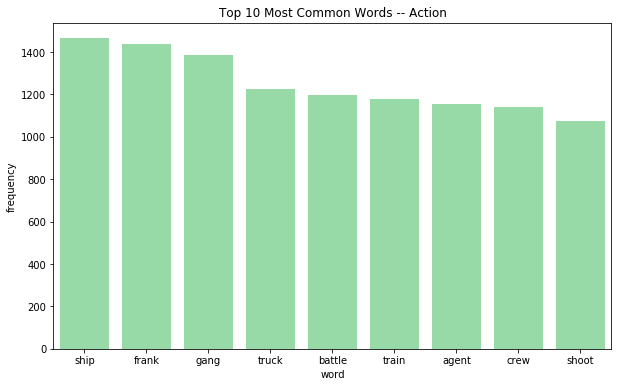

In [26]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(new_cleaned_action)
freq_df_action = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_action = freq_df_action.sum(axis=0).sort_values(ascending=False).reset_index()

f, ax = plt.subplots(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(x=top_action.iloc[0:9,0], y=top_action.iloc[0:9,1],
            label="Total", color="g")
ax.set(ylabel="frequency",
       xlabel="word",
       title="Top 10 Most Common Words -- Action")
f.show()

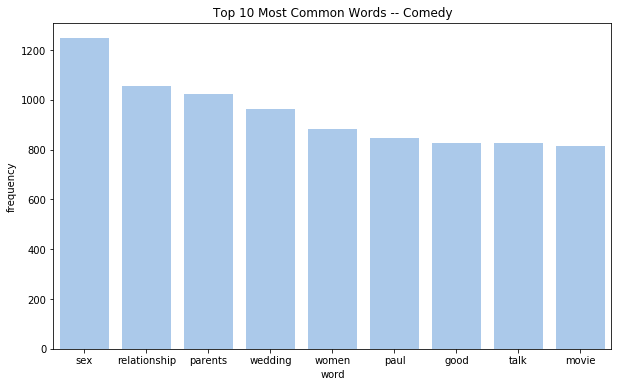

In [27]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(new_cleaned_comedy)
freq_df_comedy = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_comedy = freq_df_comedy.sum(axis=0).sort_values(ascending=False).reset_index()

f, ax = plt.subplots(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(x=top_comedy.iloc[0:9,0], y=top_comedy.iloc[0:9,1],
            label="Total", color="b")
ax.set(ylabel="frequency",
       xlabel="word",
       title="Top 10 Most Common Words -- Comedy")
f.show()

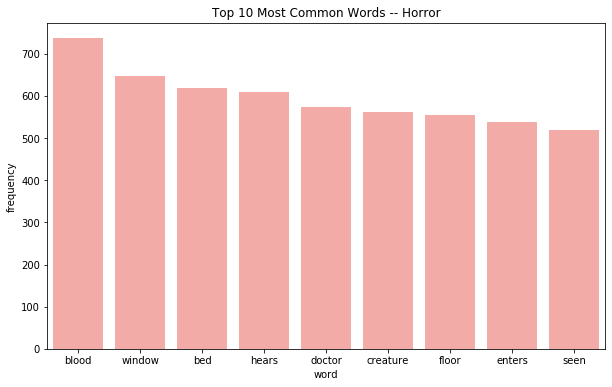

In [28]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(new_cleaned_horror)
freq_df_horror = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_horror = freq_df_horror.sum(axis=0).sort_values(ascending=False).reset_index()

f, ax = plt.subplots(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(x=top_horror.iloc[0:9,0], y=top_horror.iloc[0:9,1],
            label="Total", color="r")
ax.set(ylabel="frequency",
       xlabel="word",
       title="Top 10 Most Common Words -- Horror")
f.show()

These top 10 most common words look a lot better now!!

In [29]:
## clean all text
cleaned_plot = movies_keep['plot_synopsis'].apply(lambda x: new_clean_text(x))

In [34]:
## calculate tf-idf scores
tf = TfidfVectorizer(max_df=.99, min_df=.01)
X_plot = tf.fit_transform(cleaned_plot)
plot_tfidf = pd.DataFrame(X_plot.toarray(), columns=tf.get_feature_names())
plot_tfidf.head()

10  100   11   12   15   18   20  200   24   25  ...  yells  yes  yet  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0  0.0   

       york  younger  youngest  youth  zombie  zombies  zone  
0  0.071144      0.0       0.0    0.0     0.0      0.0   0.0  
1  0.000000      0.0       0.0    0.0     0.0      0.0   0.0  
2  0.000000      0.0       0.0    0.0     0.0      0.0   0.0  
3  0.000000      0.0       0.0    0.0     0.0      0.0   0.0  
4  0.000000      0.0       0.0    0.0     0.0      0.0   0.0  

[5 rows x 5014 columns]

### Additional EDA

#### runtimeMinutes

In [58]:
## violin plots for runtime by genre
sns.violinplot(x="genre", y="runtimeMinutes", palette='hls', data=movies_keep)

#### averageRating

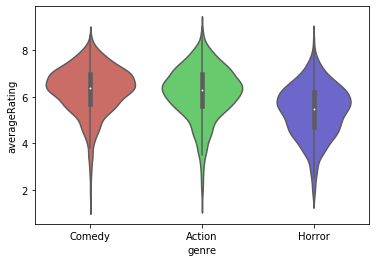

In [59]:
sns.violinplot(x="genre", y="averageRating", palette='hls', data=movies_keep)

#### numVotes

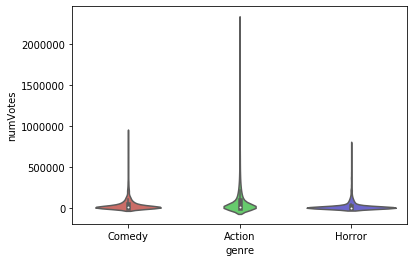

In [60]:
sns.violinplot(x="genre", y="numVotes", palette='hls', data=movies_keep)

### K-Means Clustering and PCA

In [65]:
movies_keep.head()

primaryTitle  runtimeMinutes  averageRating  numVotes  \
0                   Kate & Leopold           118.0            6.4     78334   
1               Halls of Montezuma           113.0            6.6      2458   
2               Anne of the Indies            81.0            6.7      1173   
3           Callaway Went Thataway            81.0            6.5       593   
4  Captain Horatio Hornblower R.N.           117.0            7.3      6052   

                                       plot_synopsis   genre  
0  On 28 April 1876, Leopold, His Grace the 3rd D...  Comedy  
1  During World War II, a Marine battalion prepar...  Action  
2  After seizing a British ship, the barefoot, fe...  Action  
3  Mike Frye (MacMurray) and Deborah Patterson (M...  Comedy  
4  In 1807, during the Napoleonic Wars, British R...  Action

In [68]:
## instantiate, fit, and transform the minmaxscaler on runtime, rating, and votes features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(movies_keep[['runtimeMinutes', 'averageRating', 'numVotes']])
scaled_X = pd.DataFrame(data=scaled, columns = ['runtimeMinutes', 'averageRating', 'numVotes'])

In [71]:
## combine scaled features with tf-idf scores from the synopsis text
X_df = pd.concat([scaled_X, plot_tfidf], axis=1, join_axes=[scaled_X.index])
X_df.head()

runtimeMinutes  averageRating  numVotes   10  100   11   12   15   18   20  \
0        0.264493       0.657895  0.034509  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        0.246377       0.684211  0.001078  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2        0.130435       0.697368  0.000512  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3        0.130435       0.671053  0.000256  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4        0.260870       0.776316  0.002661  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   ...  yells  yes  yet      york  younger  youngest  youth  zombie  zombies  \
0  ...    0.0  0.0  0.0  0.071144      0.0       0.0    0.0     0.0      0.0   
1  ...    0.0  0.0  0.0  0.000000      0.0       0.0    0.0     0.0      0.0   
2  ...    0.0  0.0  0.0  0.000000      0.0       0.0    0.0     0.0      0.0   
3  ...    0.0  0.0  0.0  0.000000      0.0       0.0    0.0     0.0      0.0   
4  ...    0.0  0.0  0.0  0.000000      0.0       0.0    0.0     0.0      0.0   

   zone  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  

[5 rows x 5017 columns]

In [72]:
## k-means cluster analysis for multiple values of k
wcss = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_df)
    wcss.append(kmeans.inertia_)

In [74]:
## make elbow plot (theoretically, the optimal value of k should be at 3)
plt.plot(np.arange(1,10), wcss, 'ok-')
plt.xlabel('Number of Clusters, K')
plt.ylabel('WCSS')

Text(0, 0.5, 'WCSS')

There is a local elbow at `k = 2`, but because I know that the data has 3 genre categories, I'm going to go with 3 clusters. It's not unreasonable.

In [87]:
## fit k-means and determine the cluster centers
km = KMeans(n_clusters=3, random_state=80109)
km.fit(X_df)
centers = pd.DataFrame(km.cluster_centers_, columns=X_df.columns)

## determine top features from each cluster
order_centroids = km.cluster_centers_.argsort()[:,::-1]

for i in range(3):
    print("Cluster %d:" % i, end='\n')
    for ind in order_centroids[i, :10]:
        print(' %s' % X_df.columns[ind] + ': ' + 
              str(round(centers.loc[i, X_df.columns[ind]], 3)), end='\n')
    print()

Cluster 0:
 averageRating: 0.763
 runtimeMinutes: 0.262
 numVotes: 0.053
 bond: 0.013
 gang: 0.012
 frank: 0.012
 train: 0.012
 harry: 0.011
 ship: 0.011
 sam: 0.011

Cluster 1:
 averageRating: 0.383
 runtimeMinutes: 0.177
 girls: 0.011
 johnny: 0.01
 attacked: 0.01
 creature: 0.009
 zombies: 0.009
 sister: 0.009
 vampire: 0.009
 blood: 0.009

Cluster 2:
 averageRating: 0.608
 runtimeMinutes: 0.194
 numVotes: 0.015
 joe: 0.011
 paul: 0.011
 sam: 0.01
 nick: 0.01
 gang: 0.01
 mike: 0.01
 ben: 0.009



In [86]:
## look at first 2 principle components colored by cluster label
pca = PCA(n_components=2, random_state=80109)
pca.fit(X_df)
prnc_comp = pca.transform(X_df)
plt.scatter(prnc_comp[:,0], prnc_comp[:,1], c=km.labels_)

A quick look at the first two principal components of the fully processed data indicates that there is clear separation between clusters (the three genres that make up the target variable). That being said, there aren't clear clusters. The plot above just looks like one big blob. 

Throughout the data cleaning process, I made an effort to select genres that would seem to be naturally distinct from each other. This could be argued and I of course acknowledge the overlap of themes or events in these types of movies; but Action, Comedy, and Horror films are different enough from each other in nature to perhaps lend themselves to analysis (instead of something like Action, Adventure, and Drama). Additionally, creating an expansive list of plot "stop words," which are words that are common in storywriting, reinforced the already present differences between these genres. 

I feel comfortable proceeding with the model section of this project, knowing that effort was made to make the target categories as distinct as possible.

(it could be possible that adding in the extra variables runtime, average rating, and votes adds too much noise to the information derived from the text of the plot. in a quick exploration of those three variables, they didn't appear to be very different between genres and it is likely that they aren't very helpful in making classifications. it could be worth exploring how well the genres separate, and how well my models can predict, with just the movie synopses.)

## Methods and Results

### Random Forest

### Extreme Gradient Boosting

### Naive Bayes